# Vehicle time response reliability on vehicle automation: Evidence from experimental driving modes in platooning conditions

## Finding Response Time 

The following files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob 
from functools import partial 
import operator

In [2]:
# Catch al files 
files2load = glob.glob("data/raw/*.csv")
files2load

['data/raw/data5.csv',
 'data/raw/data6.csv',
 'data/raw/data9.csv',
 'data/raw/data12.csv',
 'data/raw/data13.csv',
 'data/raw/data10.csv']

In [3]:
# Load files 
lst_datas = []
for file in files2load:
    lst_datas.append(pd.read_csv(file, sep = ',', decimal = '.'))

# 
keys = [x.split('.')[0].split('/')[-1] for x in files2load] 
dfTotal = pd.concat(lst_datas,keys=keys , names = ['Experiment'])

# Compute spacing between vehicles and their leaders. 

for i in (1,2,3,4):
    if i==1:
        dfTotal[f'distToLeader_f{i}'] = dfTotal[f'follower{i}_radar1']
    else:
        dfTotal[f'distToLeader_f{i}'] = dfTotal[f'follower{i-1}_radar1']+dfTotal[f'follower{i}_radar1']
    

In [4]:
# Clean data 
lst_datas_flt = [] 

for i in range(5):
    if i == 0: 
        lead_clean = dfTotal[~dfTotal['leader_GPS_CARMA_speed'].isna()]
        follower_clean = lead_clean.copy()
        lst_datas_flt.append(lead_clean)
    else: 
        follower_clean = follower_clean[~follower_clean[f'follower{i}_GPS_CARMA_speed'].isna()]
        lst_datas_flt.append(follower_clean)
    
dfFilter = pd.concat(lst_datas_flt).drop_duplicates()

# Cliping values between 0 ~ 50 (for min speed) 

dfCliped=dfFilter.copy()
dfCliped['leader_GPS_CARMA_speed'] = dfCliped['leader_GPS_CARMA_speed'].clip(0,50)

# Sorting values
dfSorted = dfCliped.reset_index().sort_values(by=['Heure','Time']).set_index(['Experiment','level_1'])

In [75]:
def plot_exps(df,col):
    f,ax = plt.subplots(1,len(keys), figsize = (20,5))
    f.suptitle(col)
    for x, a in zip(df.groupby('Experiment'),ax.flatten()):
        x[1].plot(x='Time',y=col,ax=a,title = f'Exp. {x[0]}', grid =True);
        a.get_legend().remove()
    return f,ax

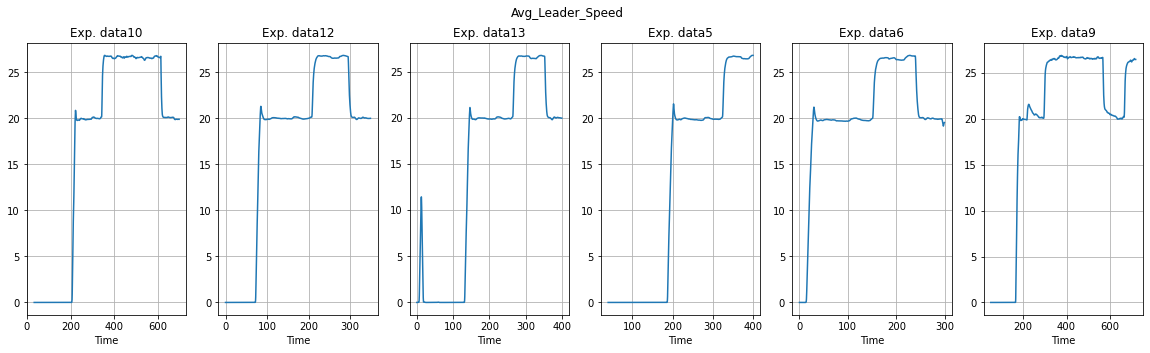

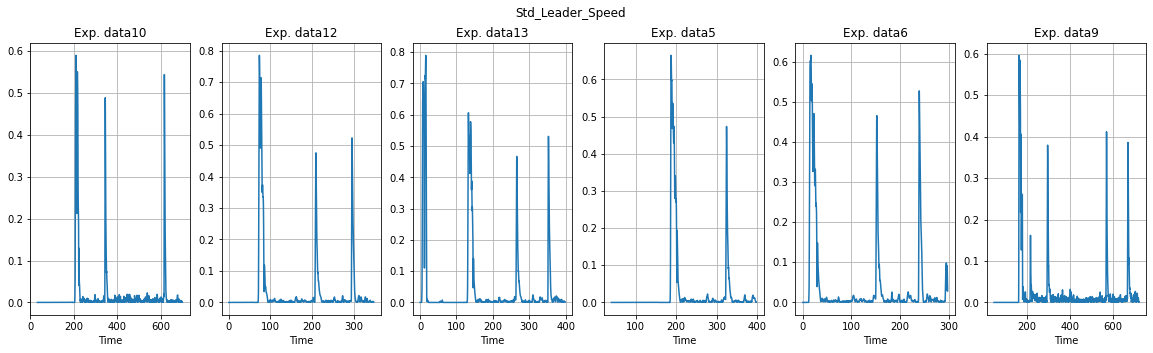

In [76]:
# Moving average 
lst_ma_spd = [] 
lst_sd_spd = [] 
h = 10 # Window size

# Forward indexer (to account for k+h instead of classic k-h)
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=h)

# Find average speed 
for key in keys:
    lst_ma_spd.append(dfSorted.loc[(key,slice(None)),'leader_GPS_CARMA_speed'].rolling(window=indexer).mean())
dfSorted['Avg_Leader_Speed'] = pd.concat(lst_ma_spd)

# Find standard deviation From Avg. Speed
for key in keys:
    lst_sd_spd.append(dfSorted.loc[(key,slice(None)),'Avg_Leader_Speed'].rolling(window=indexer).std())
dfSorted['Std_Leader_Speed'] = pd.concat(lst_sd_spd)

# Find derivative of Std. 
lst_dsd_spd = []
for key in keys: 
    lst_dsd_spd.append(dfSorted.loc[(key,slice(None)),'Std_Leader_Speed'].diff())
dfSorted['Diff_Std_Leader_Speed'] = pd.concat(lst_dsd_spd)
dfSorted['Abs_Diff_Std_Leader_Speed'] = abs(dfSorted['Diff_Std_Leader_Speed'])

# Plot info
plot_exps(dfSorted, 'Avg_Leader_Speed');
plot_exps(dfSorted, 'Std_Leader_Speed');

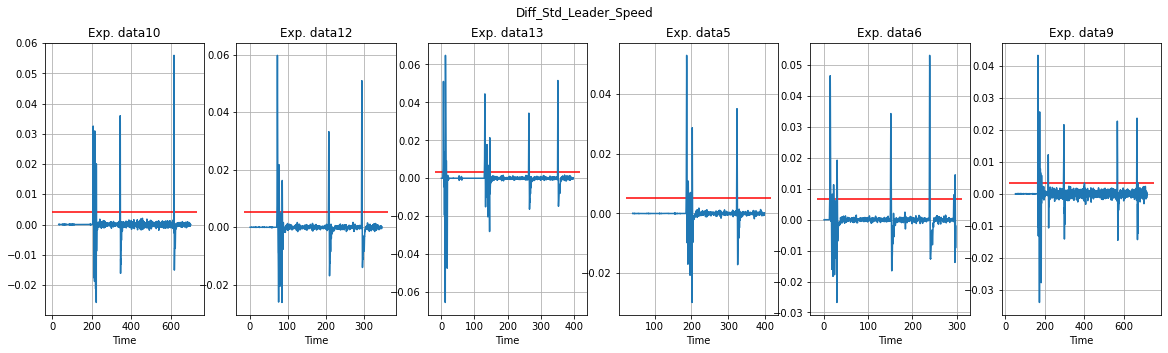

In [77]:
dct_sd_sdspd = {}
for key in keys:
    dct_sd_sdspd[key]=dfSorted.loc[(key,slice(None)),'Std_Leader_Speed'].diff().std()

f,a = plot_exps(dfSorted, 'Diff_Std_Leader_Speed')
for dctv, ax in zip(dct_sd_sdspd.items(),a.flatten()):
    key, val = dctv
    ax.hlines(val,*ax.get_xlim(),color='r')


In [78]:
FORWARD_WINDOW = 20
indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

FACTOR_SPEED_CHG = 95
# perc = partial(lambda x,y: np.percentile(y,x),FACTOR_SPEED_CHG)

l_prc80 = [] 
l_select = [] 
for key in keys: 
    print(f"Processing: {key}")
    
    # Compute future window percentile over Abs(Diff(std)) -> 
    l_prc80.append(dfSorted.loc[(key,slice(None)),"Abs_Diff_Std_Leader_Speed"].rolling(window=indexerFuture).apply(np.percentile, args = (FACTOR_SPEED_CHG,)).dropna())

    # Select appropiate ones: Mark as true samples which 80 perc > 
    l_select.append(l_prc80[-1]>dct_sd_sdspd[key])
    
dfSorted['Change'] = pd.concat(l_select)
dfSorted['Change'].fillna(False,inplace=True)

Processing: data5
Processing: data6
Processing: data9
Processing: data12
Processing: data13
Processing: data10


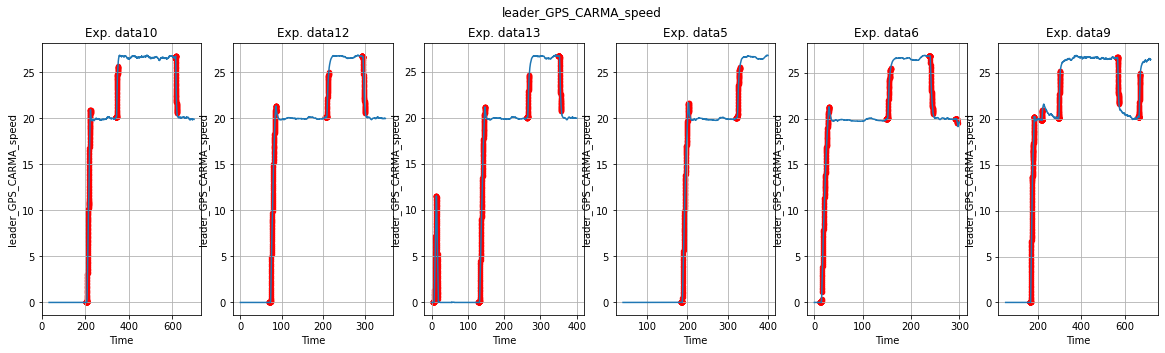

In [79]:
f,a = plot_exps(dfSorted, 'leader_GPS_CARMA_speed')
for dfitems, ax in zip(dfSorted.groupby('Experiment'),a.flatten()):
    key, df = dfitems
    df[df.Change].plot(x='Time',y='leader_GPS_CARMA_speed', ax = ax, kind='scatter', color = 'r', grid = True)

In [80]:
# Get first occurences 

FORWARD_WINDOW = 10
indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

# Computing Percentage of Samples ahead
l_detection = []
l_ratio = []
for key in keys:
    
    # Find % of Samples 
    total = dfSorted.loc[(key,slice(None)),'Change'].rolling(window=indexerFuture).sum()
    count = dfSorted.loc[(key,slice(None)),'Change'].rolling(window=indexerFuture).count()
    ratio = total.divide(count)

    bool_ratio= ratio.astype(bool)
    bool_detection = bool_ratio.rolling(2).apply(lambda x: not x[0] and x[1]).dropna() # Peak detections via XoR
    l_ratio.append(ratio)
    
    # We delete the last sample this is the change produced by NaN values. 
    l_detection.append(bool_detection[:-FORWARD_WINDOW]) 

dfSorted['Detections'] = pd.concat(l_detection)

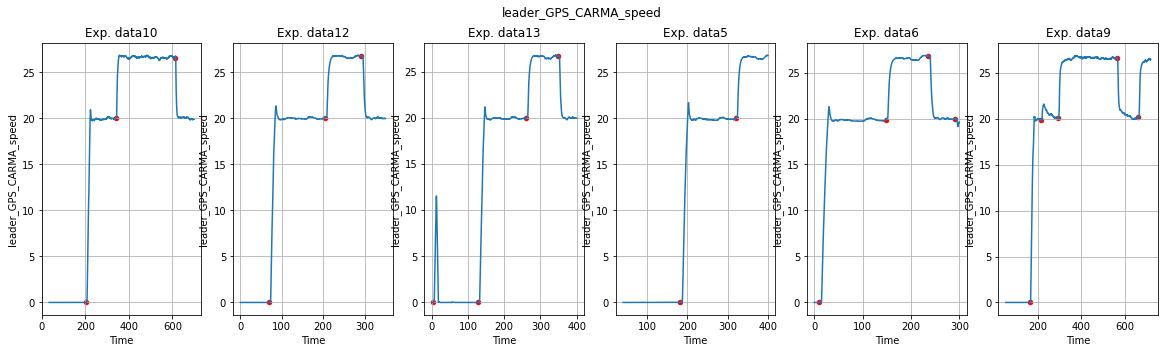

In [84]:
dfDetections = dfSorted[dfSorted['Detections']>0][['Time','leader_GPS_CARMA_speed']]
f,a = plot_exps(dfSorted, 'leader_GPS_CARMA_speed')
for dfitems, ax in zip(dfDetections.groupby('Experiment'),a.flatten()):
    key, df = dfitems
    df.plot(x='Time',y='leader_GPS_CARMA_speed', ax = ax, kind='scatter', color = 'r', grid = True)

In [63]:
dfDetections

Time  leader_GPS_CARMA_speed
Experiment level_1                               
data12     685       68.5                   0.000
           2043     204.3                  20.096
           2917     291.7                  26.780
data13     26         2.6                   0.000
           1277     127.7                   0.001
           2607     260.7                  19.985
           3484     348.4                  26.733
data5      1829     182.9                   0.001
           3198     319.8                  19.992
data6      103       10.3                   0.000
           1476     147.6                  19.867
           2355     235.5                  26.785
           2906     290.6                  19.949
data9      1610     161.0                   0.000
           2136     213.6                  19.916
           2916     291.6                  20.056
           5636     563.4                  26.608
           6624     662.4                  20.218
data10     2022     202.2                   0.000
           3393     339.3                  20.085
           6113     611.3                  26.593

# Followers

In [100]:
def plot_followers(df,cols):
    f,ax = plt.subplots(1,len(keys), figsize = (20,5))
    f.suptitle('')
    for x, a in zip(df.groupby('Experiment'),ax.flatten()):
        [x[1].plot(x='Time',y=col,ax=a,title = f'Exp. {x[0]}', grid =True) for col in cols]
#         a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
        a.get_legend().remove()
    return f,ax

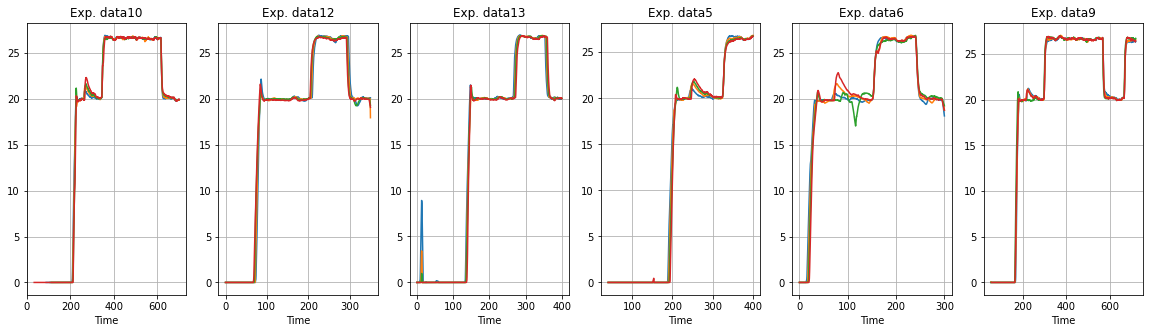

In [104]:
followers = [f'follower{i}_GPS_CARMA_speed' for i in range(1,5)]

# Cleaning negative values 
dfClipedF=dfSorted.copy()
dfClipedF[followers] = dfCliped[followers].clip(0,50)

plot_followers(dfClipedF,followers);

In [110]:
def detect_column(df):
    # Moving average 
    lst_ma_spd = [] 
    lst_sd_spd = [] 
    h = 10 # Window size

    # Forward indexer (to account for k+h instead of classic k-h)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=h)

    # Find average speed 
    for key in keys:
        lst_ma_spd.append(df.loc[(key,slice(None)),:].rolling(window=indexer).mean())
    df['Avg_Speed'] = pd.concat(lst_ma_spd)

    # Find standard deviation From Avg. Speed
    for key in keys:
        lst_sd_spd.append(df.loc[(key,slice(None)),'Avg_Speed'].rolling(window=indexer).std())
    df['Std_Speed'] = pd.concat(lst_sd_spd)

    # Find derivative of Std. 
    lst_dsd_spd = []
    for key in keys: 
        lst_dsd_spd.append(df.loc[(key,slice(None)),'Std_Speed'].diff())
    df['Diff_Std_Speed'] = pd.concat(lst_dsd_spd)
    df['Abs_Diff_Std_Leader_Speed'] = abs(dfSorted['Diff_Std_Speed'])
    
    
    FORWARD_WINDOW = 20
    indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

    FACTOR_SPEED_CHG = 95

    l_prc80 = [] 
    l_select = [] 
    for key in keys: 
        print(f"Processing: {key}")

        # Compute future window percentile over Abs(Diff(std)) -> 
        l_prc80.append(df.loc[(key,slice(None)),"Abs_Diff_Std_Leader_Speed"].rolling(window=indexerFuture).apply(np.percentile, args = (FACTOR_SPEED_CHG,)).dropna())

        # Select appropiate ones: Mark as true samples which 80 perc > 
        l_select.append(l_prc80[-1]>dct_sd_sdspd[key])

    df['Change'] = pd.concat(l_select)
    df['Change'].fillna(False,inplace=True)

    # Get first occurences 
    FORWARD_WINDOW = 10
    indexerFuture = pd.api.indexers.FixedForwardWindowIndexer(window_size=FORWARD_WINDOW)

    # Computing Percentage of Samples ahead
    l_detection = []
    l_ratio = []
    for key in keys:

        # Find % of Samples 
        total = df.loc[(key,slice(None)),'Change'].rolling(window=indexerFuture).sum()
        count = df.loc[(key,slice(None)),'Change'].rolling(window=indexerFuture).count()
        ratio = total.divide(count)

        bool_ratio= ratio.astype(bool)
        bool_detection = bool_ratio.rolling(2).apply(lambda x: not x[0] and x[1]).dropna() # Peak detections via XoR
        l_ratio.append(ratio)

        # We delete the last sample this is the change produced by NaN values. 
        l_detection.append(bool_detection[:-FORWARD_WINDOW]) 

    df['Detections'] = pd.concat(l_detection)
    dfDetections = df[df['Detections']>0]
    return dfDetections

In [111]:
for col in dfClipedF[followers]:
    x = dfClipedF[col].apply(detect_column)
    break

AttributeError: 'float' object has no attribute 'loc'

In [ ]:
#chargement des .csv
for i in RunNo:
    globals()["data{}".format(i)] = pd.read_csv('data/raw/data{}.csv'.format(i), sep = ',', decimal = '.', low_memory = False)

In [ ]:
#création d'une colonne pour avoir la distance au leader pour chacun des véhicules
#on récupérera les distances au leader de chaque véhicule aux instants de changement de réponse
for i in RunNo:
    globals()['data{}'.format(i)]['distToLeader_f1'] = globals()['data{}'.format(i)].follower1_radar1 
    globals()['data{}'.format(i)]['distToLeader_f2'] = globals()['data{}'.format(i)].follower1_radar1 + globals()['data{}'.format(i)].follower2_radar1     
    globals()['data{}'.format(i)]['distToLeader_f3'] = globals()['data{}'.format(i)].follower1_radar1 + globals()['data{}'.format(i)].follower2_radar1 + globals()['data{}'.format(i)].follower3_radar1 
    globals()['data{}'.format(i)]['distToLeader_f4'] = globals()['data{}'.format(i)].follower1_radar1 + globals()['data{}'.format(i)].follower2_radar1 + globals()['data{}'.format(i)].follower3_radar1 + globals()['data{}'.format(i)].follower4_radar1 

In [ ]:
#suppression des valeurs manquantes
for i in RunNo:
    for j in range(5):
        if j ==0:
            globals()['data{}'.format(i)] = globals()['data{}'.format(i)][globals()['data{}'.format(i)]
                                                                          .leader_GPS_CARMA_speed.isna() == False]
        else:
            globals()['data{}'.format(i)] = globals()['data{}'.format(i)]
            [globals()['data{}'.format(i)]['follower{}_GPS_CARMA_speed'.format(j)].isna() == False]


In [ ]:
#refonte de l'index
for i in RunNo:
    globals()["data{}".format(i)] = globals()["data{}".format(i)].reset_index(drop = True)

In [ ]:
#tri des valeurs par 'Time'
for i in RunNo:
    globals()['data{}'.format(i)] = globals()['data{}'.format(i)].sort_values(by = 'Time')

In [ ]:
#on reprend les index
for i in RunNo:
    globals()['data{}'.format(i)] = globals()['data{}'.format(i)].reset_index(drop = True)

In [ ]:
#h représente la plage de données sur laquelle les valeurs de vitesse vont être moyennées
#on choisit h = 1s, avec une fréquence de 10 Hz, ça représente 10 valeurs par seconde
h = 10

### Traitement des leader

La première étape consiste à déterminer les instants de changement de réponse pour les leader qui sont à l'origine d'un changement de vitesse des suiveurs.

In [ ]:
#on définit les variables moyenne et écart type
for i in RunNo:
    globals()['mu{}_leader'.format(i)] = []
    globals()['sigma{}_leader'.format(i)] = []
    for k in range(len(globals()["data{}".format(i)].Time) - h):
        #on calcule la moyenne des vitesses sur la plage [i - 10 ; i + 10]
        globals()['mu{}_leader'.format(i)].append(np.mean([globals()["data{}".format(i)].leader_GPS_CARMA_speed[j] 
                                                           for j in range(k, k + h)]))

In [ ]:
#on définit sigma pour tout élément de mu comme l'écart type des valeurs de vitesse moyennées sur la tranche de largeur h
for i in RunNo:
    for k in range(len(globals()["mu{}_leader".format(i)]) - h):
        globals()['sigma{}_leader'.format(i)].append(np.std([globals()["mu{}_leader".format(i)][j] for j in range(k, k + h)]))
        